# threshold selection for key retreival

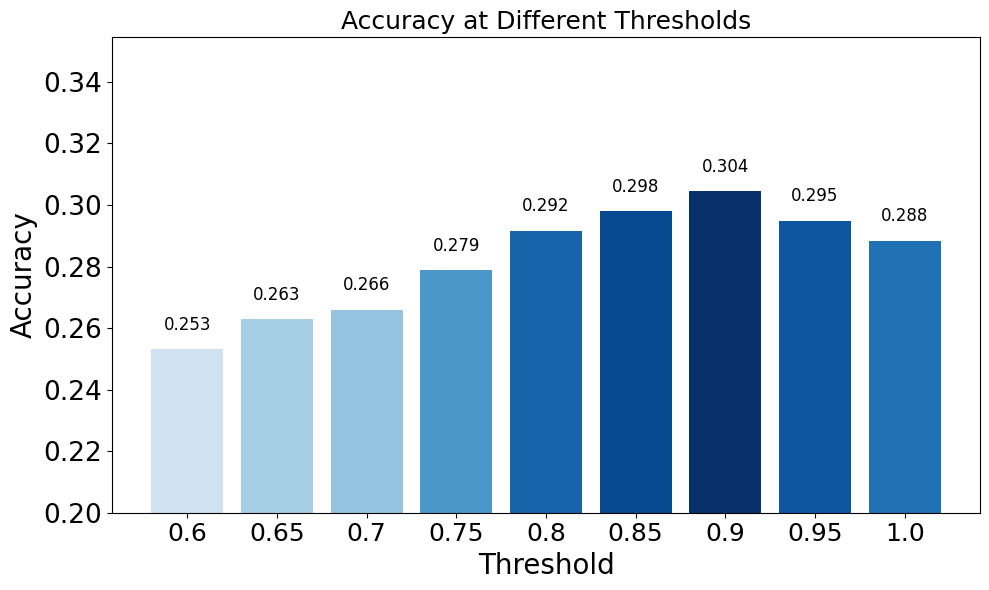

In [ ]:
import json
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def cal_accuracy(threshold):
    with open(f"./key_threshold/key_{threshold}.json", "r", encoding="utf-8") as f:
        loaded_results = json.load(f)
    cor = 0
    for result in loaded_results:
        if result["predicted_label"] == result["correct_label"]:
            cor += 1
    loaded_acc = cor / len(loaded_results)
    return loaded_acc

thresholds = [round(0.6 + 0.05 * i, 2) for i in range(9)]
acc = []
for threshold in thresholds:
    acc.append((threshold, cal_accuracy(threshold)))

x_labels = [str(t[0]) for t in acc]
y_values = [t[1] for t in acc]

norm = plt.Normalize(min(y_values), max(y_values))
colors = [cm.Blues(0.2 + 0.8 * norm(v)) for v in y_values]

plt.figure(figsize=(10, 6))
bars = plt.bar(x_labels, y_values, color=colors)

for bar, acc_value in zip(bars, y_values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.005,
             f"{acc_value:.3f}", ha='center', va='bottom', fontsize=12)

plt.xlabel("Threshold", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.title("Accuracy at Different Thresholds", fontsize=18)

plt.xticks(fontsize=18)
plt.yticks(fontsize=19)

plt.ylim(0.2, max(y_values) + 0.05)
plt.tight_layout()
plt.savefig("./fig/threshold.png", dpi=300)
plt.show()

# heatmap of different coefficients for different weights

/opt/anaconda3/envs/486proj/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


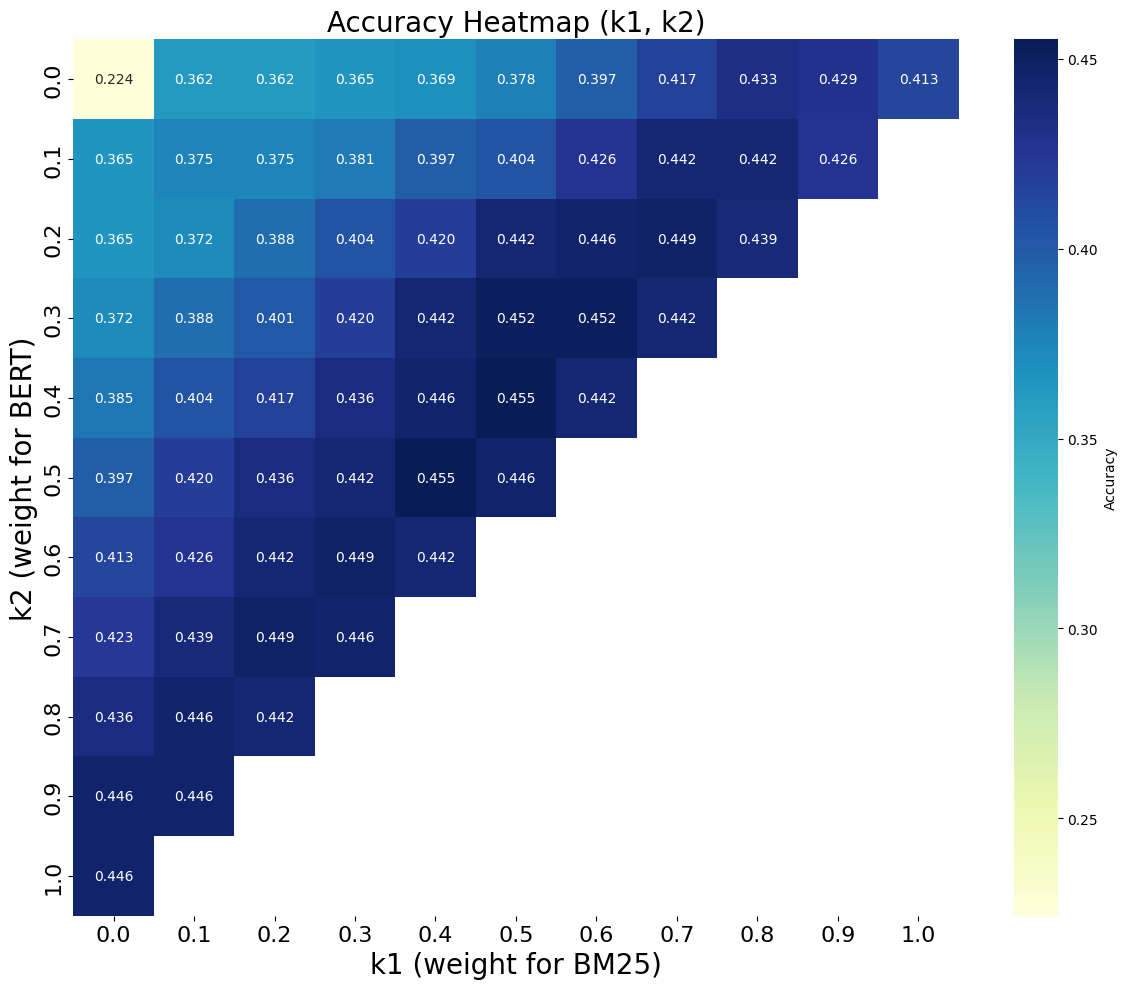

✅ Best Accuracy: 0.4551
   Best weight: k1 (BM25)= 0.50, k2 (BERT)= 0.40, k3 (KEY)= 0.10


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils import combine_results
import json

with open('./train/train_bm25.json', 'r', encoding='utf-8') as f:
    bm25 = json.load(f)
with open('./train/train_bert.json', 'r', encoding='utf-8') as f:
    bert = json.load(f)
with open('./train/train_key.json', 'r', encoding='utf-8') as f:
    key = json.load(f)

k_vals = np.round(np.arange(0.0, 1.01, 0.1), 2)
heatmap_data = []
best_acc = -1
best_k1 = None
best_k2 = None

for k2 in k_vals:
    row = []
    for k1 in k_vals:
        if k1 + k2 <= 1.0:
            acc = combine_results(bm25, bert, key, k1=k1, k2=k2)
            if acc > best_acc:
                best_acc = acc
                best_k1 = k1
                best_k2 = k2
        else:
            acc = np.nan
        row.append(acc)
    heatmap_data.append(row)

df = pd.DataFrame(heatmap_data, index=k_vals, columns=k_vals)

plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    df,
    annot=True,
    fmt=".3f",
    cmap="YlGnBu",
    cbar_kws={'label': 'Accuracy'},
)

ax.set_xlabel("k1 (weight for BM25)", fontsize=20)
ax.set_ylabel("k2 (weight for BERT)", fontsize=20)
ax.set_title("Accuracy Heatmap (k1, k2)", fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)

plt.tight_layout()
plt.savefig("fig/accuracy_heatmap.png", dpi=300)
plt.show()

print(f"✅ Best Accuracy: {best_acc:.4f}")
print(f"   Best weight: k1 (BM25)= {best_k1:.2f}, k2 (BERT)= {best_k2:.2f}, k3 (KEY)= {1 - best_k1 - best_k2:.2f}")


# evalution for top_k accuracy

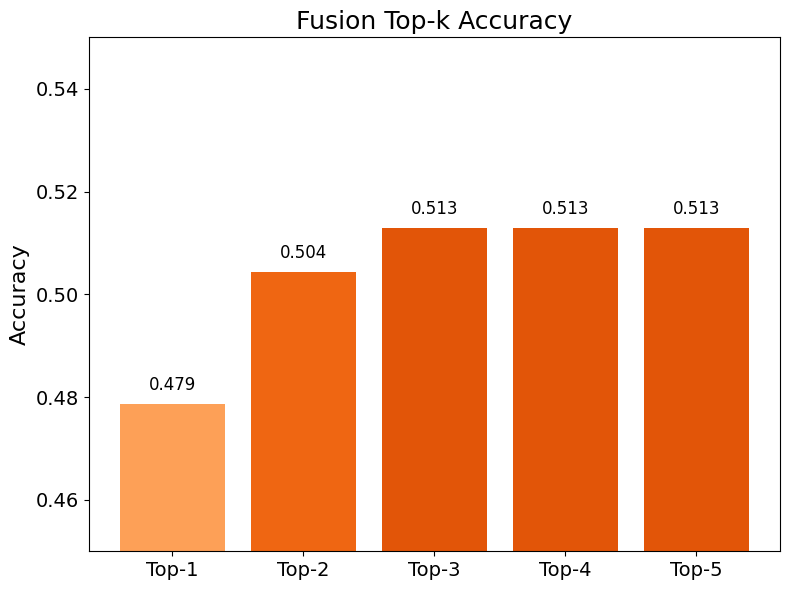

In [9]:
import json
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from utils import compute_topk_accuracy_fusion

with open('./test/bm25_true.json', 'r', encoding='utf-8') as f:
    bm25 = json.load(f)
with open('./test/bert.json', 'r', encoding='utf-8') as f:
    bert = json.load(f)
with open('./test/key.json', 'r', encoding='utf-8') as f:
    key = json.load(f)

topk_acc = compute_topk_accuracy_fusion(bm25, bert, key, k1=0.5, k2=0.4, top_k_eval=5)

k_labels = [f"Top-{k}" for k in range(1, 6)]
y_values = topk_acc

norm = plt.Normalize(0.45, 0.55)
colors = [cm.Oranges(0.2 + 0.8 * norm(v)) for v in y_values]

plt.figure(figsize=(8, 6))
bars = plt.bar(k_labels, y_values, color=colors)

for bar, acc_value in zip(bars, y_values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.002,
             f"{acc_value:.3f}", ha='center', va='bottom', fontsize=12)

plt.ylim(0.45, 0.55)
plt.ylabel("Accuracy", fontsize=16)
plt.title("Fusion Top-k Accuracy", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.savefig("./fig/fusion_topk_accuracy.png", dpi=300)
plt.show()


# evaluate overall output
## baseline

In [21]:
with open("output/nli_baseline.json", "r") as f:
    results = json.load(f)
entailment_count = sum(1 for item in results if item.get("nli_label") == "entailment")
total = len(results)
entailment_ratio = entailment_count / total if total > 0 else 0
print(f"Entailment count: {entailment_count}/{total}")
print(f"Entailment proportion: {entailment_ratio:.2%}")

Entailment count: 26/56
Entailment proportion: 46.43%


## our method

In [ ]:
import json
with open("output/nli_results.json", "r") as f:
    results = json.load(f)
entailment_count = sum(1 for item in results if item.get("nli_label") == "entailment")
total = len(results)
entailment_ratio = entailment_count / total if total > 0 else 0
print(f"Entailment count: {entailment_count}/{total}")
print(f"Entailment proportion: {entailment_ratio:.2%}")


Entailment count: 36/56
Entailment proportion: 64.29%
